# Simple Sentence Similarity

Word embeddings have become widespread in Natural Language Processing. They allow us to easily compute the semantic similarity between two words, or to find the words most similar to a target word. However, in many applications we're more interested in the similarity between two sentences or short texts. In this notebook, I compare some simple ways of computing sentence similarity and investigate how they perform.

## Data

### STS Benchmark

The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark


In [2]:
import pandas as pd
import scipy
import math
import os
import tensorflow as tf

def load_sts_dataset(filename):
    # Loads a subset of the STS dataset into a DataFrame. In particular both
    # sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
        fname="Stsbenchmark.tar.gz",
        origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
        extract=True)

    sts_dev = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

    return sts_dev, sts_test

sts_dev, sts_test = download_and_load_sts_data()

In [3]:
sts_test[:5]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


### SICK data

In [5]:
import requests

def download_sick(f): 

    response = requests.get(f).text

    lines = response.split("\n")[1:]
    lines = [l.split("\t") for l in lines if len(l) > 0]
    lines = [l for l in lines if len(l) == 5]

    df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
    df['sim'] = pd.to_numeric(df['sim'])
    return df
    
sick_train = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_dev = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
sick_test = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_test_annotated.txt")


In [6]:
sick_train[:5]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


## Preprocessing

In [7]:
import nltk

STOP = set(nltk.corpus.stopwords.words("english"))

class Sentence:
    
    def __init__(self, sentence):
        self.raw = sentence
        normalized_sentence = sentence.lower().replace("‘", "'").replace("’", "'")
        self.tokens = [t for t in nltk.word_tokenize(sentence) if t not in STOP]


## Similarity methods

### Baseline

As our baseline, we're going for the simplest way of computing sentence embeddings: just take the embeddings of the words in the sentence (minus the stopwords), and compute their average, weighted by the sentence frequency of each word. 

We'll then use the cosine to calculate the similarity between two sentence embeddings.

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

def sum_embeddings(tokens, model):
    return sum([model[token] for token in tokens if token in model])/len(tokens)

def cosine1(tokens1, tokens2, model): 
    embedding1 = sum_embeddings(tokens1, model).reshape(1, -1)
    embedding2 = sum_embeddings(tokens2, model).reshape(1, -1)
    
    return cosine_similarity(embedding1, embedding2)

def run_avg_benchmark_word2vec(sentences1, sentences2): 
    return [cosine1(sent1.tokens, sent2.tokens, gensim_model_word2vec)[0][0] for (sent1, sent2) in zip(sentences1, sentences2)]

def run_avg_benchmark_glove(sentences1, sentences2): 
    return [cosine1(sent1.tokens, sent2.tokens, gensim_model_glove)[0][0] for (sent1, sent2) in zip(sentences1, sentences2)]

### Spacy

In [47]:
import spacy

nlp = spacy.load("en_core_web_lg")

def run_spacy_benchmark(sentences1, sentences2): 
    return [nlp(sent1.raw).similarity(nlp(sent2.raw)) for (sent1, sent2) in zip(sentences1, sentences2)]

### Word mover's distance

Word mover's distance is a popular alternative to the simple average embedding similarity. The Word Mover's Distance uses the word embeddings of the words in two texts to measure the minimum amount that the words in one text need to "travel" in semantic space to reach the words of the other text. Word mover's distance is available in the popular Gensim library.

In [42]:
import gensim
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.scripts.glove2word2vec import glove2word2vec

word2vec_path = "/Users/yvespeirsman/Corpora/WordVectors/GoogleNews-vectors-negative300.bin"
glove_path = "/Users/yvespeirsman/Corpora/WordVectors/glove.840B.300d.txt"

#model = gensim.models.KeyedVectors.load_word2vec_format("/Users/yvespeirsman/data/fastText/fr/wiki_100000.fr.vec")
gensim_model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

tmp_file = "/tmp/glove.840B.300d.w2v.txt"
glove2word2vec(glove_path, tmp_file)
gensim_model_glove = gensim.models.KeyedVectors.load_word2vec_format(tmp_file)

In [43]:
def run_wmd_benchmark_word2vec(sentences1, sentences2):
    return [-gensim_model_word2vec.wmdistance(sent1.tokens, sent2.tokens) for (sent1, sent2) in zip(sentences1, sentences2)]

def run_wmd_benchmark_glove(sentences1, sentences2):
    return [-gensim_model_glove.wmdistance(sent1.tokens, sent2.tokens) for (sent1, sent2) in zip(sentences1, sentences2)]

### Smooth Inverse Frequency

Get word frequencies from reference corpus such as Wikipedia.

In [12]:
frequencies = {}
with open("frequencies.tsv") as i:
    for line in i:
        line = line.strip().split("\t")
        frequencies[line[0]] = int(line[1])

To compute SIF sentence embeddings, we first compute a weighted average of the token embeddings in the sentence. This procedure is very similar to the weighted average we used above, with the single difference that the word embeddings are weighted by `a/a+p(w)`, where `w` is a parameter that is set to `0.001` by default, and `p(w)` is the estimated relative frequency of a word in a reference corpus such as Wikipedia.

In [14]:
def weighted_average_embeddings(tokens, freqs, a=0.001):
    total_freq = sum(freqs.values())
    
    sentence_embedding = np.zeros(300)
    for token in tokens:
        if token in gensim_model:
            weight = a/(a+freqs.get(token,0)/total_freq)
            token_embedding = gensim_model[token]
            sentence_embedding += weight * token_embedding
    sentence_embedding /= len(tokens)
    return sentence_embedding
        

Next, we need to perform common component removal: we compute the principal component of the sentence embeddings we obtained above and subtract from them their projections on this first principal component. This corrects for the influence of high-frequency words that mostly have a syntactic or discourse function, such as "just", "there", "but", etc. 

In [16]:
from sklearn.decomposition import TruncatedSVD

def remove_first_principal_component(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    XX = X - X.dot(pc.transpose()) * pc
    return XX


def run_sif_benchmark(sentences1, sentences2): 
    sentence_embeddings = []
    
    # SIF requires us to first collect all sentence embeddings and then perform 
    # common component analysis.
    for (sent1, sent2) in zip(sentences1, sentences2): 
        embedding1 = weighted_average_embeddings(sent1.tokens, frequencies)
        embedding2 = weighted_average_embeddings(sent2.tokens, frequencies)

        sentence_embeddings.append(embedding1)
        sentence_embeddings.append(embedding2)
        
    sif_sims = []
    embeddings_for_sif = remove_first_principal_component(np.array(sentence_embeddings))
    for idx in range(int(len(sentence_embeddings)/2)): 
        embedding1 = sentence_embeddings[idx*2].reshape(1, -1)
        embedding2 = sentence_embeddings[idx*2+1].reshape(1, -1)
        sim = cosine_similarity(embedding1, embedding2)[0][0]
        sif_sims.append(sim)

    return sif_sims


### Google Sentence Encoder

In [17]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [18]:
tf.logging.set_verbosity(tf.logging.ERROR)
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

In [19]:
def run_gse_benchmark(sentences1, sentences2):
    sts_input1 = tf.placeholder(tf.string, shape=(None))
    sts_input2 = tf.placeholder(tf.string, shape=(None))

    sts_encode1 = tf.nn.l2_normalize(embed(sts_input1))
    sts_encode2 = tf.nn.l2_normalize(embed(sts_input2))
        
    sim_scores = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
      
        [gse_sims] = session.run(
            [sim_scores],
            feed_dict={
                sts_input1: [sent1.raw for sent1 in sentences1],
                sts_input2: [sent2.raw for sent2 in sentences2]
            })
    return gse_sims


### InferSent

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/SentEval/master/examples/models.py
!wget https://s3.amazonaws.com/senteval/infersent/infersent.allnli.pickle

In [20]:
import torch

infersent = torch.load('infersent.allnli.pickle', map_location=lambda storage, loc: storage)
infersent.use_cuda = False

infersent.set_glove_path(glove_path)

/Users/yvespeirsman/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/yvespeirsman/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [21]:
def run_inf_benchmark(sentences1, sentences2):
    
    raw_sentences1 = [sent1.raw for sent1 in sentences1]
    raw_sentences2 = [sent2.raw for sent2 in sentences2]
    
    infersent.build_vocab(raw_sentences1 + raw_sentences2, tokenize=True)
    embeddings1 = infersent.encode(raw_sentences1, tokenize=True)
    embeddings2 = infersent.encode(raw_sentences2, tokenize=True)
    
    inf_sims = []
    for (emb1, emb2) in zip(embeddings1, embeddings2): 
        sim = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]
        inf_sims.append(sim)

    return inf_sims    

## Experiments

In [35]:
def run_experiment(df, benchmarks): 
    
    sentences1 = [Sentence(s) for s in df['sent_1']]
    sentences2 = [Sentence(s) for s in df['sent_2']]
    
    results = []
    for label, method in benchmarks:
        sims = method(sentences1, sentences2)
        pearson_correlation = scipy.stats.pearsonr(sims, df['sim'])[0]
        print(label, pearson_correlation)
        results.append(pearson_correlation)
        
    return results

In [48]:
benchmarks = [("AVG-W2V", run_avg_benchmark_word2vec),
              ("AVG-GLOVE", run_avg_benchmark_glove),
              ("WMD-W2V", run_wmd_benchmark_word2vec), 
              ("WMD-GLOVE", run_wmd_benchmark_glove), 
              ("SPACY", run_spacy_benchmark), 
              ("SIF", run_sif_benchmark), 
              ("GSE", run_gse_benchmark), 
              ("INF", run_inf_benchmark)]

results = {}
results["SICK-DEV"] = run_experiment(sick_dev, benchmarks)
results["SICK-TEST"] = run_experiment(sick_test, benchmarks)
results["STS-DEV"] = run_experiment(sts_dev, benchmarks)
results["STS-TEST"] = run_experiment(sts_test, benchmarks)


AVG-W2V 0.6807758500465102
AVG-GLOVE 0.6489807517892621
WMD-W2V 0.6084992388068139
WMD-GLOVE 0.6109008925446218
SPACY 0.639281159053343
Running SIF benchmark
SIF 0.6797767718965236
Running GSE benchmark
GSE 0.7282557455668891
Running INF benchmark
Found 1121(/1122) words with glove vectors
Vocab size : 1121
INF 0.7008594698958657
AVG-W2V 0.7013252067023191
AVG-GLOVE 0.6765999568968976
WMD-W2V 0.6090334015900284
WMD-GLOVE 0.604632708760861
SPACY 0.6647556918342541
Running SIF benchmark


KeyboardInterrupt: 

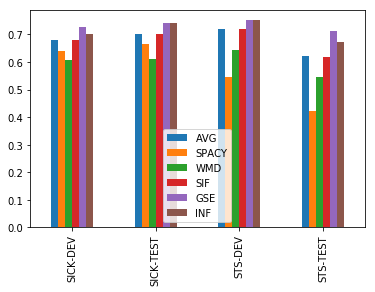

In [40]:
results_df = pd.DataFrame(results)
results_df = results_df.transpose()
results_df = results_df.rename(columns={i:method[0] for i, method in enumerate(benchmarks)})

results_df.plot(kind="bar")